In [5]:
import os
import shap
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import xgboost as xgb
import catboost as cb
from sklearn import tree, svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, LeaveOneOut 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold
from tqdm import tqdm
from sklearn.feature_selection import RFECV
import division_into_classes as dic

In [6]:
cognitive_indicator = 'corsi'
indicator_folder = "D:/unn/down_syndrome_epigenetic/corsi"
alpha = 0.001

correlation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\correlation_frame.txt", sep = '\t', index_col = 0)
methylation_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\methylation_frame.txt", sep = '\t', index_col = 0)
cognitive_frame = pd.read_csv(r"D:\unn\down_syndrome_epigenetic\corsi\cognitive_frame.txt", sep = '\t', index_col = 0)

In [7]:
classes_all_members, classes_unique_members = dic.division_into_classes (cognitive_indicator, cognitive_frame)
print('Division into classes \nall values:', *classes_all_members, '\nunique values:', *classes_unique_members)
division_method = int(input('\nChoose how to divide into classes:\n1. all values\n2. unique values\n3. manual division\n'))
if division_method == 3:
    print(sorted(list(cognitive_frame[cognitive_indicator])))
    lim1, lim2 = [int(i) for i in input('Enter boundary values: ').split(' ')]
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method, lim1, lim2)
else:
    indicator_classes = dic.division_into_classes(cognitive_indicator, cognitive_frame, division_method)

Division into classes 
all values: 14 8 6 
unique values: 9 13 6

Choose how to divide into classes:
1. all values
2. unique values
3. manual division
2


In [8]:
methylation_frame

,cg21870274,cg00168193,cg08258224,cg16619049,cg18147296,cg13938959,cg12445832,cg23999112,cg11527153,cg27573606,...,cg25529319,cg01747155,cg06659128,cg00763725,cg12403148,cg07311845,cg09975171,cg12115116,cg12830022,cg07211220
1001,0.883678,0.918437,0.713809,0.458695,0.827997,0.484169,0.316901,0.496508,0.893755,0.952782,...,0.059140,0.017747,0.107710,0.052176,0.092420,0.038735,0.132265,0.406396,0.746943,0.921020
1003,0.857414,0.924492,0.829528,0.616295,0.848691,0.574863,0.419684,0.623289,0.890015,0.958883,...,0.264385,0.427492,0.368880,0.498435,0.590506,0.350458,0.436376,0.615756,0.685776,0.914987
1007,0.834939,0.900506,0.728498,0.548257,0.805198,0.583334,0.412387,0.574073,0.864494,0.956064,...,0.290230,0.450082,0.300523,0.520191,0.560589,0.290128,0.463533,0.612994,0.697647,0.909535
1009,0.839568,0.890795,0.748410,0.545118,0.827682,0.500970,0.374761,0.556291,0.829674,0.952492,...,0.048362,0.015056,0.093314,0.044131,0.059133,0.031133,0.159050,0.335846,0.773084,0.886070
1010,0.740502,0.919526,0.716631,0.485524,0.739984,0.515279,0.349854,0.582334,0.822567,0.961240,...,0.057367,0.018607,0.082015,0.054236,0.089922,0.037760,0.193004,0.357331,0.770881,0.892118
1011,0.738885,0.906828,0.757804,0.521394,0.779136,0.514136,0.375304,0.573896,0.849877,0.956148,...,0.353115,0.403050,0.338211,0.487042,0.519079,0.351921,0.454704,0.658609,0.745893,0.833074
1013,0.829321,0.910300,0.872942,0.696943,0.819519,0.594700,0.432738,0.644559,0.887436,0.956855,...,0.291090,0.455632,0.295129,0.516700,0.541187,0.291550,0.436757,0.658063,0.782022,0.926083
1020,0.830481,0.910844,0.823697,0.593059,0.853179,0.567125,0.416065,0.598897,0.876642,0.959810,...,0.062498,0.020848,0.089537,0.040530,0.074946,0.031105,0.143218,0.296005,0.789495,0.934812
1023,0.797700,0.885494,0.856847,0.560247,0.824752,0.473320,0.374224,0.533452,0.865969,0.953027,...,0.322973,0.456130,0.372286,0.488424,0.560245,0.267174,0.449657,0.670745,0.779370,0.904777
1028,0.849718,0.902979,0.798962,0.502172,0.835325,0.554379,0.390621,0.604273,0.838084,0.958423,...,0.113449,0.115817,0.178048,0.096273,0.124200,0.066019,0.144071,0.288751,0.738754,0.929525


In [9]:
indicator_classes

,value,class
0,0.0,0
1,3.0,1
2,3.0,1
3,3.0,1
4,1.0,0
5,3.0,1
6,4.0,2
7,2.0,1
8,3.0,1
9,0.0,0


1) LDA error:

In [13]:
X = methylation_frame[list(correlation_frame.index)]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

lda_model = LDA()
params = [{'solver': ['svd', 'lsqr', 'eigen']}]

grid_cv = GridSearchCV(estimator = lda_model, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
y_pred = grid_cv.predict(X_test)

print('LDA:', '\nbest params:', best_params, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

LDA: 
best params: {'solver': 'svd'} 
CV error = 0.5900000000000001 
Accuracy = 0.5 
F = 0.3571428571428572



5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "D:\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 599, in fit
    self._solve_eigen(
  File "D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "C:\Users\kozlo\AppData\Roaming\Python\Python39\site-packages\scipy\linalg\_decomp.py", line 594, in eigh
    raise LinAlgError('The leading minor of order {} of B is not '

In [12]:
X = methylation_frame[list(correlation_frame.index)]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

lda_model = LDA()
params = {'solver': ['svd', 'lsqr', 'eigen']}

grid_cv = GridSearchCV(estimator = lda_model, param_grid = params, cv = 5, n_jobs = -1, error_score='raise')
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
y_pred = grid_cv.predict(X_test)

print('LDA:', '\nbest params:', best_params, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

LinAlgError: The leading minor of order 16 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

2) SHAP error:

  0%|          | 0/28 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

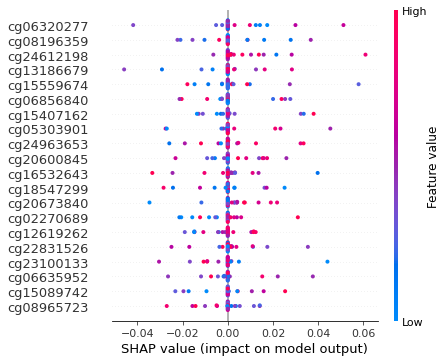

In [14]:
X = methylation_frame[correlation_frame.index].values
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111, stratify = y)

model = svm.SVC(kernel = 'rbf', probability=True)
params = {'gamma': [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0],
          'coef0': [0.0001, 0.001, 0.01, 0.1, 0.2, 1.0],
          'C': [40, 50, 60, 70, 80, 90]} 

grid_cv = GridSearchCV(estimator = model, param_grid = params, scoring = 'accuracy', cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
y_pred = grid_cv.predict(X_test)
  
explainer = shap.KernelExplainer(grid_cv.predict, X)
shap_values = explainer.shap_values(X)    
indicator_folder_SHAP = '{0}/SHAP'.format(indicator_folder)
if not os.path.isdir(indicator_folder_SHAP):
        os.mkdir(indicator_folder_SHAP)
    
x, y = 15, 12
fig_inch = (x/2.54, y/2.54)
fig = plt.figure()
shap.summary_plot(shap_values, features = X, feature_names = correlation_frame.index, show = False)
plt.gcf().set_size_inches(fig_inch)
fig.patch.set_facecolor('white')
fig.savefig('{0}/beeswarm.png'.format(indicator_folder_SHAP), format = 'png', dpi = 300, bbox_inches = 'tight')

for patient_number in range(len(shap_values)):
    fig = plt.figure()
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[patient_number], 
                                           feature_names = correlation_frame.index, show = False)
    plt.gcf().set_size_inches(fig_inch)
    fig.patch.set_facecolor('white')
    fig.savefig('{0}/waterfall_legacy_{1}.png'.format(indicator_folder_SHAP, patient_number), 
                    format = 'png', dpi = 300, bbox_inches = 'tight')
    plt.close()

3) Переменные коллинеарны:

In [15]:
X = methylation_frame[list(correlation_frame.index)]
y = indicator_classes['class']

X = (X - X.mean(axis = 0)) / X.std(axis = 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 111)

qda_model = QDA()
params = {'reg_param': [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}

grid_cv = GridSearchCV(estimator = qda_model, param_grid = params, cv = 5, n_jobs = -1)
grid_cv.fit(X_train, y_train)
    
best_params = grid_cv.best_params_
cv_err = grid_cv.best_score_
y_pred = grid_cv.predict(X_test)

print('LDA:', '\nbest params:', best_params, '\nCV error =', cv_err, 
     '\nAccuracy =', accuracy_score(y_test, y_pred), '\nF =', f1_score(y_test, y_pred, average = 'macro'))

LDA: 
best params: {'reg_param': 0.1} 
CV error = 0.45 
Accuracy = 0.3333333333333333 
F = 0.26666666666666666


Variables are collinear
